<a href="https://colab.research.google.com/github/Anurag38/tic-tac-toe/blob/master/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip '/content/drive/MyDrive/CECS550/HW3/lfw.zip'

Streaming output truncated to the last 5000 lines.
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0021.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0021.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0020.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0020.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0008.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0008.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0022.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0022.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0023.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0023.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0012.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0012.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep

# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [4]:
path = '/content/lfw'

In [5]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [6]:
if torch.backends.mps.is_available():
    device = torch.device("cuda")
else:
    print ("CUDA device not found.")


CUDA device not found.


torch.Size([250, 250, 3])


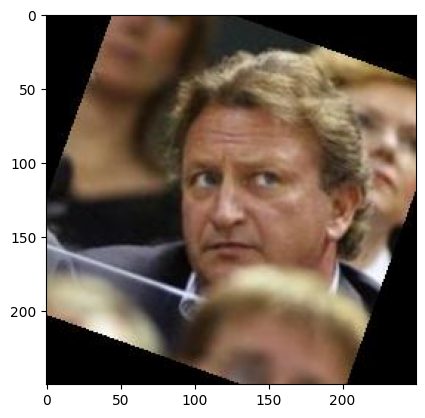

In [7]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In [8]:
#Step 2

# Getting a random image from the dataloader
for images, _ in dataloader:
    sample_image = images[3]
    break

print("Dimensions of the image:", sample_image.shape)

print("\nExplanation of each dimension:")
print("First Dimension: Channels - ", sample_image.shape[0], " : This represents the number of color channels i.e RGB")
print("Second Dimension: Height - ", sample_image.shape[1], " : This represents the number of pixels that makes up the height")
print("Third Dimension: Width - ", sample_image.shape[2], " : This represents the number of pixels that makes up the width")


Dimensions of the image: torch.Size([3, 250, 250])

Explanation of each dimension:
First Dimension: Channels -  3  : This represents the number of color channels i.e RGB
Second Dimension: Height -  250  : This represents the number of pixels that makes up the height
Third Dimension: Width -  250  : This represents the number of pixels that makes up the width


# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AE(nn.Module):
    def __init__(self):
      super(AE, self).__init__()

      #Encoder Layers
      self.encoder_layers = nn.Sequential(
          nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
          nn.BatchNorm2d(256),
          nn.ReLU()
      )

      # Decoder Layer
      self.decoder_layers = nn.Sequential(
          nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, output_padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, output_padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, output_padding=1),
          nn.BatchNorm2d(3),
          nn.Upsample(size=(250, 250), mode='bilinear', align_corners=False),
          nn.Sigmoid()
      )

    def encoder(self, x):
        return self.encoder_layers(x)

    def decoder(self, x):
        return self.decoder_layers(x)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [10]:
# Create an instance of the AE class
model = AE()

# Input tensor (batch size, channels, height, width)
sample_input = torch.randn(1, 3, 250, 250)

# Check if CUDA is available and move the model and input to GPU if it is
if torch.cuda.is_available():
    model = model.cuda()
    sample_input = sample_input.cuda()

# Pass the dummy image through the model
with torch.no_grad():
    encoded_output = model.encoder(sample_input)
    decoded_output = model.decoder(encoded_output)

# Print the shapes of the outputs
print("Shape of encoded output:", encoded_output.shape)
print("Shape of decoded output:", decoded_output.shape)


Shape of encoded output: torch.Size([1, 256, 31, 31])
Shape of decoded output: torch.Size([1, 3, 250, 250])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [11]:
import torch.nn as nn
import torch.optim as optim
import torch.optim as optim

#Total number of parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of trainable parameters:", total_params)

Total number of trainable parameters: 1318793


## Reason for using MSELoss

#### The primary objective of an autoencoder is to learn a compressed representation of the input data in its latent space and then reconstruct the input data as accurately as possible. The MSE Loss measures the average squared difference between the input and the reconstructed output.

In [12]:
# Loss function
loss_function = nn.MSELoss()

# Optimizer
optim = optim.Adam(model.parameters(), lr=0.001)

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [13]:
num_epochs = 10
for epoch in range(num_epochs):
    epoch_loss = 0.0

    for data in dataloader:
        inputs, _ = data
        if torch.cuda.is_available():
            inputs = inputs.cuda()

        # Zero the parameter gradients
        optim.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = loss_function(outputs, inputs)

        # Backward pass and optimize
        loss.backward()
        optim.step()

        epoch_loss += loss.item()

    # Average loss for the epoch
    epoch_loss /= len(dataloader)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

Epoch 1, Loss: 0.0160
Epoch 2, Loss: 0.0060
Epoch 3, Loss: 0.0037
Epoch 4, Loss: 0.0029
Epoch 5, Loss: 0.0026
Epoch 6, Loss: 0.0024
Epoch 7, Loss: 0.0022
Epoch 8, Loss: 0.0021
Epoch 9, Loss: 0.0020
Epoch 10, Loss: 0.0020


#### If the loss in the training of an autoencoder is not decreasing,
*   adjust the learning rate as it can affect convergence.
*   inspect the model complexity.


##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

In [14]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np
import torch

# Fetch a batch of images
batch_images, _ = next(iter(dataloader))

# Select one image randomly
rand_idx = torch.randint(high=len(batch_images), size=(1,)).item()
selected_image = batch_images[rand_idx]

In [15]:
# Reshape for model input and transfer to GPU if available
model.eval()
if torch.cuda.is_available():
    model.cuda()
    selected_image = selected_image.unsqueeze(0).cuda()
else:
    selected_image = selected_image.unsqueeze(0)

with torch.no_grad():
    output_image = model(selected_image)

In [16]:
# Preparing images for display
selected_image_np = np.transpose(selected_image.squeeze().detach().cpu().numpy(), (1, 2, 0))
output_image_np = np.transpose(output_image.squeeze().detach().cpu().numpy(), (1, 2, 0))

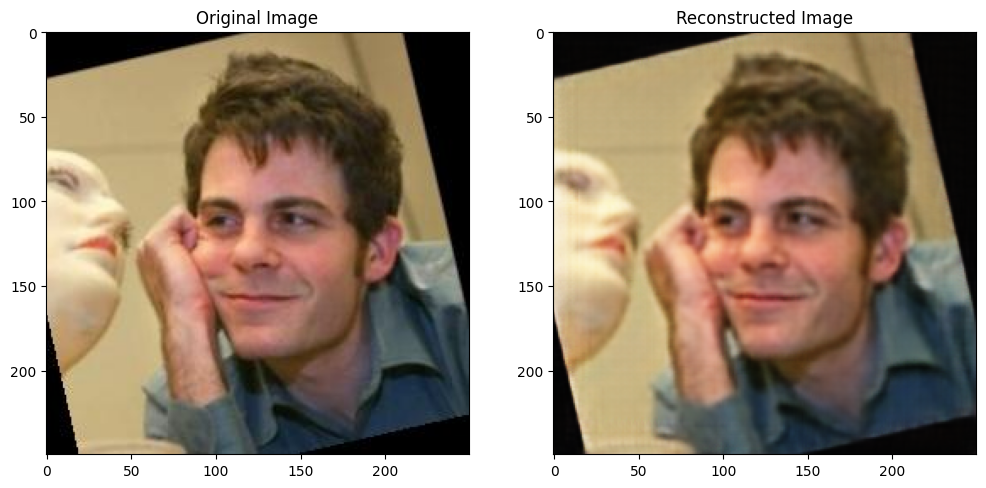

In [17]:
# Plotting original image and the reconstructed image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(selected_image_np)

plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
plt.imshow(output_image_np)

plt.show()

##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

## Impact of adding noise to latent representation of input image

#### Adding a small normally distributed noise to the output of an autoencoder's encoder can act as a regularization technique. It encourages the autoencoder to generate reconstructions that are less sensitive to minor variations in the input data.

In [18]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images from the dataloader
batch_data = next(iter(dataloader))
batch_images, _ = batch_data

# Choose a random image from the batch
rand_idx = torch.randint(high=len(batch_images), size=(1,)).item()
chosen_image = batch_images[rand_idx]

In [19]:
# Set the model to evaluation mode
model.eval()
if torch.cuda.is_available():
    model.to('cuda')
    chosen_image = chosen_image.unsqueeze(0).to('cuda')
else:
    chosen_image = chosen_image.unsqueeze(0)

In [20]:
# Encoding the image and introducing noise
with torch.no_grad():
    latent_repr = model.encoder(chosen_image)
    # Adding some Gaussian noise
    added_noise = torch.randn_like(latent_repr) * 0.1
    latent_with_noise = latent_repr + added_noise

    # Decoding the latent representations
    decoded_img = model.decoder(latent_repr)
    decoded_noisy_img = model.decoder(latent_with_noise)

In [21]:
# Helper function to format the tensor for plotting
def format_for_plotting(tensor):
    np_img = tensor.squeeze().detach().cpu().numpy()
    np_img = np.transpose(np_img, (1, 2, 0))
    return np_img

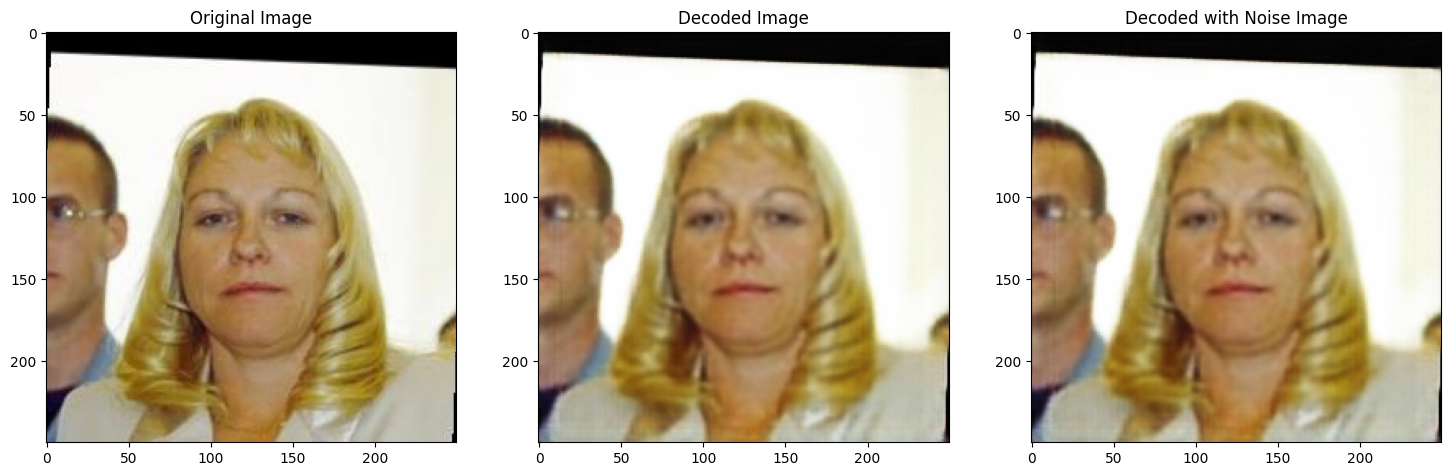

In [22]:
# Plot the original, reconstructed, and noisy reconstructed images
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(format_for_plotting(chosen_image))


plt.subplot(1, 3, 2)
plt.title("Decoded Image")
plt.imshow(format_for_plotting(decoded_img))


plt.subplot(1, 3, 3)
plt.title("Decoded with Noise Image")
plt.imshow(format_for_plotting(decoded_noisy_img))


plt.show()

####  From this assignment we can get to know the practical implementation of Auto-encoders. They are a versatile neural network model which is primarily used for dimensionality reduction, noise reduction in images and in generative models.

#### Reference -

1.   ChatGPT
2.   https://geeksforgeeks.org/implementing-an-autoencoder-in-pytorch/


